<h2><center>Restricted open-shell Hartree–Fock for Beryllium</center></h2>

<p style="text-align: center; margin-top: 0px; margin-bottom: 0px;">
                By <a target="_blank" href="https://github.com/yueyericardo">Richard Xue </a>
</p>

<p style="text-align: center; margin-top: 0px;">
                <a target="_blank" href="https://yyrcd.com/hf/he.html">Helium </a>&nbsp;/&nbsp;
                <a target="_blank" href="https://yyrcd.com/hf/li.html">Lithium </a>&nbsp;/&nbsp;    
                <a target="_blank" href="https://yyrcd.com/hf/be.html">Beryllium </a>
</p>


In [441]:
import sympy as sp
from sympy import oo
import numpy as np
from itertools import product
from scipy.linalg import eig
from sympy import diff
import time as time
import matplotlib.pyplot as plt
from sympy.plotting import plot
# %matplotlib notebook 
%matplotlib inline
from IPython.display import Math
sp.init_printing()
from sympy import expand_func
from sympy.functions import conjugate
from sympy import nsimplify
from sympy.functions.special.tensor_functions import KroneckerDelta
from sympy.physics.wigner import gaunt
from sympy.physics.wigner import wigner_3j

zeta, zeta1, zeta2 = sp.symbols("zeta, zeta1, zeta2")
n = sp.Symbol('n',integer=True)
r = sp.Symbol('r',real = True)
zeta = sp.Symbol('zeta',real = True)
theta = sp.Symbol('theta',real = True)
phi = sp.Symbol('phi',real = True)
r1 = sp.Symbol('r1',positive = True)
r2 = sp.Symbol('r2',positive = True)
l, m = sp.symbols("l, m")

<h2><center>Part 1 Function Definition</center></h2>

### Define STO function
$STO \; function \; has \; format \; of: \; Nr^{n-1}e^{-r\zeta}$

In [221]:
def STO(zeta, n, l=0, m=0, r=r):
    return expand_func((2*zeta)**n*(2*zeta/sp.factorial(2*n))**(1/2)*r**(n-1)*sp.exp(-zeta*r)*(sp.Ynm(l, m, theta, phi)))

def STO_r(zeta, n, l=0, m=0, r=r):
    return (2*zeta)**n*(2*zeta/sp.factorial(2*n))**(1/2)*r**(n-1)*sp.exp(-zeta*r)

def Y(l=0, m=0):
    return expand_func((sp.Ynm(l, m, theta, phi)))

def Y_int(f1, f2):
    return sp.integrate(conjugate(f1)*f2*sp.sin(theta), (theta, 0, sp.pi), (phi, 0, 2*sp.pi))


In [222]:
f3 = STO_r(1.49, 1, 1, 0)

a = S_int_r(f3, f3)
a

### Overlap Integrate

$S = \int_{0}^\infty f_1^* f_2 \; r^2dr$

In [179]:
f3

In [180]:
conjugate(f3)

In [185]:
# S Overlap Integrate
def S_int(f1, f2):
    return sp.integrate(conjugate(f1)*f2*r*r*sp.sin(theta) ,(r, 0, +oo), (theta, 0, sp.pi), (phi, 0, 2*sp.pi))

def S_int_r(f1, f2):
    return sp.integrate(conjugate(f1)*f2*r*r ,(r, 0, +oo))

### Hamiltonian core

H core = kinetics energy + electron and nuclear potential energy

$H = \int_{0}^\infty f_1 \hat{H} f_2 \; r^2dr$

$H = \int_{0}^\infty f_1 ((-\dfrac{1}{2}) \nabla^2 - \dfrac{Z_{\alpha}}{r})f_2 \; r^2 dr$

<p><a href="https://en.wikipedia.org/wiki/Laplace_operator">$Laplace \; operator: $</a> $\nabla^2$</p>
<p><left><img class = "none"style="text-align: center; margin-left:0px" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b4a3135d1cc01d19309d36c749aaef4a48dc81da"></left></p>

$\therefore H = \int_{0}^\infty f_1 ((-\dfrac{1}{2}) \dfrac{1}{r} \dfrac{\partial}{\partial r} \dfrac{\partial}{\partial r} r f_2 - \dfrac{Z_{\alpha}}{r}r^2 f_2 )dr$

**reminder:** change the Z of nucleus if you want to run for other atom

In [113]:
# H core = kinetics energy + electron and nuclear potential energy
def H_int(f1, f2, Z):
    a = (1/r)*diff(diff(r*f2, r), r)
    b = (1/(r*r*sp.sin(theta)))*diff(sp.sin(theta)*diff(f2, theta), theta)
    c = (1/(r*r*sp.sin(theta)*sp.sin(theta)))*diff(diff(f2, phi), phi)    
    return sp.integrate(f1*(-((1/2)*(a))-((Z/r)*f2))*r*r*sp.sin(theta), (r,0,+oo), (theta, 0, sp.pi), (phi, 0, 2*sp.pi))


In [102]:
# Returns the core hamiltonian matrix
def H_matrix(fs, Z):

    H = np.zeros((len(fs),len(fs)))
    for i in range(len(fs)):
        for j in range(len(fs)):
            H[i, j] =  H_int(fs[i], fs[j], Z)

    return H    
s
# Returns the overlap matrix
def S_matrix(fs):

    S = np.zeros((len(fs),len(fs)))
    for i in range(len(fs)):
        for j in range(len(fs)):
            S[i, j] =  S_int(fs[i], fs[j])

    return S  

### Two elecron repulsion integral
$(rs|tu) = \int \int \dfrac{f_r^*(1) f_s(1) f_t^*(2) f_u(2)}{r_{12}} \; dv_1 dv_2 $

For 1s 2s orbital

$(rs|tu)  = \int_{0}^\infty \int_{0}^\infty \dfrac{f_r^*(1) f_s(1) f_t^*(2) f_u(2)}{r_{12}} \; r_1^2dr_1\; r_2^2dr_2  $

$(rs|tu) = \int_{0}^\infty f_r^*(1) f_s(1)  \; r_1^2dr_1\int_{0}^\infty \frac{ f_t^*(2) f_u(2)}{r_{12}}\; r_2^2dr_2  $

From problem 9.14 in quantum_chemistry by levine

$(rs|tu) = \int_{0}^\infty f_r^*(1) f_s(1)  \; r_1^2dr_1\int_{0}^\infty \frac{ f_t^*(2) f_u(2)}{r_{>}}\; r_2^2dr_2  $

$(rs|tu) = \int_{0}^\infty f_r^*(1) f_s(1)  \; r_1^2dr_1(\int_{0}^{r_1} \frac{ f_t^*(2) f_u(2)}{r_{1}}\; r_2^2dr_2 + \int_{r_1}^\infty \frac{ f_t^*(2) f_u(2)}{r_{2}}\; r_2^2dr_2)  $

$Let \; B= \int_{0}^{r_1} \frac{ f_t^*(2) f_u(2)}{r_{1}}\; r_2^2dr_2 + \int_{r_1}^\infty \frac{ f_t^*(2) f_u(2)}{r_{2}}\; r_2^2dr_2$

$(rs|tu) = \int_{0}^\infty f_r^*(1) f_s(1) B \; r_1^2 dr_1  $



In [452]:
def win(l1,l2,l3,m1,m2,m3):
    if(wigner_3j(l1,l2,l3,m1,m2,m3)==0):
        return 0
    else:
        return 1

def Repulsion_electron(zetas):
    
    f1=STO_r(zetas[0][0], zetas[0][1], zetas[0][2], zetas[0][3], r1)
    f2=STO_r(zetas[1][0], zetas[1][1], zetas[1][2], zetas[1][3], r1)
    f3=STO_r(zetas[2][0], zetas[2][1], zetas[2][2], zetas[2][3], r2)
    f4=STO_r(zetas[3][0], zetas[3][1], zetas[3][2], zetas[3][3], r2)
    fs = [f1, f2, f3, f4]
    l1 = int(zetas[0][2])
    l2 = int(zetas[1][2])    
    l3 = int(zetas[2][2])
    l4 = int(zetas[3][2])
    m1 = int(zetas[0][3])
    m2 = int(zetas[1][3])
    m3 = int(zetas[2][3])
    m4 = int(zetas[3][3]) 
    print(l1, l2, l3, l4)
    
    A = 0
    B = 0
    lower = max(abs(l1-l2),abs(l3-l4))
    upper = min(l1+l2, l3+l4)    
    for l in range(lower, upper+1):
        print("caculating l = ", l)    
        for m in range(-l, l+1):
            print("caculating m = ", m )
            print("win(",l3,l4,l,m3,m4,m, "): ", win(l3,l4,l,m3,m4,m))
            print("win(",l1,l2,l,m1,m2,m, "): ", win(l1,l2,l,m1,m2,m))

            B = sp.integrate(nsimplify((((r2**l1)/(r1**(l1+1))))*f3*f4*r2*r2*win(l3,l4,l,m3,m4,m)) ,(r2, 0, r1)) + sp.integrate(nsimplify(((r1**l1)/(r2**(l1+1)))*f3*f4*r2*r2*win(l3,l4,l,m3,m4,m)) ,(r2, r1, +oo))        
            A += sp.integrate(nsimplify(f1*f2*r1*r1*B*win(l1,l2,l,m1,m2,m)) ,(r1, 0, +oo))        
    print("B: ", B)
    print("A: ", A)    
    print("finish R = ", A)
    return A
    
#     print("caculating B")    
# #     if(l1==0):
# #         B = (((1)/(r1)))*sp.integrate(nsimplify(f3*f4*r2*r2*KroneckerDelta(l3,l4)*KroneckerDelta(m3,m4)) ,(r2, 0, r1)) + sp.integrate(nsimplify(((r1**l1)/(r2**(l1+1)))*f3*f4*r2*r2*KroneckerDelta(l3,l4)*KroneckerDelta(m3,m4)) ,(r2, r1, +oo))
# #     else:
#     B = sp.integrate(nsimplify((((r2**l1)/(r1**l1)))*f3*f4*r2*r2*KroneckerDelta(l3,l4)*KroneckerDelta(m3,m4)) ,(r2, 0, r1)) + sp.integrate(nsimplify(((r1**l1)/(r2**(l1+1)))*f3*f4*r2*r2*KroneckerDelta(l3,l4)*KroneckerDelta(m3,m4)) ,(r2, r1, +oo))        
#     print(B)
#     print("caculating A")    
#     A = sp.integrate(nsimplify(f1*f2*r1*r1*B*KroneckerDelta(l1,l2)*KroneckerDelta(m1,m2)) ,(r1, 0, +oo))
#     print(A)        
#     return A


# def Repulsion_electron(zetas):
    
#     f1=STO_r(zetas[0][0], zetas[0][1], zetas[0][2], zetas[0][3], r1)
#     f2=STO_r(zetas[1][0], zetas[1][1], zetas[1][2], zetas[1][3], r1)
#     f3=STO_r(zetas[2][0], zetas[2][1], zetas[2][2], zetas[2][3], r2)
#     f4=STO_r(zetas[3][0], zetas[3][1], zetas[3][2], zetas[3][3], r2)
#     fs = [f1, f2, f3, f4]

#     B = (1/r1)*sp.integrate(nsimplify(f3*f4*r2*r2) ,(r2, 0, r1)) + sp.integrate(nsimplify((1/r2)*f3*f4*r2*r2) ,(r2, r1, +oo))
#     A = sp.integrate(f1*f2*r1*r1*B ,(r1, 0, +oo))
#     return A

In [453]:
# for i in range(0,1):
#     print(i)

gaunt(1,1,2,0,0,0)
wigner_3j(1,1,2,0,0,0)

### Density matrix
$ P_{tu} =2 \sum_{j=1}^{n/2}c_{tj}^* c_{uj} $

**Reminder:** P need to be changed if the atom have unpaired electron

In [454]:
# Calculates Density matrix
def P_matrix(Co):

    P = np.zeros([Co.shape[0], Co.shape[0]])

    for t in range(Co.shape[0]):
        for u in range(Co.shape[0]):
            for j in range(int(Co.shape[0]/2)):
                P[t][u] += 2* Co[t][j]*Co[u][j]
#             P[t][u] = 2* Co[t][1]*Co[u][1] + 2* Co[t][2]*Co[u][2] + 6* Co[t][3]*Co[u][3]                
    return P            

### Fock matrix
$ F_{rs} = H_{rs}^{core} + \sum_{t=1}^{b} \sum_{t=1}^{b}P_{tu}[(rs|tu)- \frac{1}2(ru|ts)] $  

$G = (rs|tu)- \frac{1}2(ru|ts)$ 

$ F_{rs} = H_{rs}^{core} + G $  

$In\;G \;one\;is\;coulombic\;repulsion,\;another\;is\;exchange\;energy$

In [455]:
def R_matrix(zetas):
    R = np.zeros((len(zetas), len(zetas), len(zetas), len(zetas)))*np.nan

    rstu = list(product(range(len(zetas)),repeat=4))
    i = 0
    for r, s, t, u in rstu:
        print("caculating R(",r,s,"|",t,u,")" )        
        if(np.isnan(R[r,s,t,u])):
#             print("caculating R(",r,s,"|",t,u,")" )
            value = Repulsion_electron((zetas[r], zetas[s], zetas[t], zetas[u]))            
            R[r,s,t,u] = value
            R[s,r,t,u] = value            
            R[r,s,u,t] = value
            R[s,r,u,t] = value
            R[t,u,r,s] = value
            R[u,t,r,s] = value
            R[t,u,s,r] = value
            R[u,t,s,r] = value
            i+=1
#         else:
#             print("caculating R(",r,s,"|",t,u,")","No caculation required" )
        print(R[r,s,t,u])
            #         print(i)               
    return R

# Caculate G Matrix
def G_matrix(zetas, Co, R):

    G = np.zeros((Co.shape[0], Co.shape[0]))

    P = P_matrix(Co)
    
    rs = list(product(range( Co.shape[0]),repeat=2))
    tu = list(product(range( Co.shape[0]),repeat=2))

    for r, s in rs:
        g = 0
        for t, u in tu:
            int1 = R[r, s, t, u]
            int2 = R[r, u, t, s]
#             print('({0}{1}|{2}{3}): {4}'.format(r, s, t, u, int1))
            g+= P[t, u] * (int1 - 0.5 * int2)
        G[r, s] = g
    return G

# Returns the Fock matrix
def F_matrix(fs, Z, zetas, Co, R):
    return H_matrix(fs, Z) + G_matrix(zetas, Co, R)

### Solve Hartree-Fork equation

$det(F_{rs}-\epsilon_i S_{rs} = 0)$  

$The\;energy\;returned\;is\;the\;orbital\;energy\;for\;1\;electron$

In [456]:
# slove secular equation, return the energy and improved coeffients
# the energy here is orbital energy for 1 electron
def secular_eqn(F, S):
    ei, C = eig(F, S)
    
    # sort eigvalue and eigvector from lower to higher
    idx = ei.argsort()[::1]   
    ei = ei[idx]
    C = C[:,idx]

    # eigvector from scipy.linalg.eig is not normalized, which is a bug
    # this is to fix it
    Co = np.zeros((C.shape[0],C.shape[0]))
    inte = np.matmul(np.matmul(C.T, S), C)
    for i in range(C.shape[0]):
        for j in range(C.shape[0]):
            Co[j][i]=C[j][i]/np.sqrt(inte[i][i])

    return ei, Co

### Return atom energy
$ E_{HF} = \sum_{i=1}^{2/n}\epsilon  +\frac{1}2 \sum_{r=1}^{b} \sum_{s=1}^{b}P_{rs}H_{rs}+V_{NN} $

In [457]:
# return energy of atom
def get_E0(e, P, H):
    
    E0 = 0
    for i in range(int(e.shape[0]/2)):
        E0 += e[i].real 
    E0 = E0 + 0.5*(P*H).sum()
    return E0 

<h2><center>Part 2 Hartree Fork Iteration (Main Process)</center></h2>

- Initialization
    1. initializing Co (coefficients) without considering electron repulsion
    1. Solve Hartree-Fork equation with H_matrix and S_matrix to get initial Co


- Iteration
	1. Using Co, we can get P_matrix (electron density)
	2. Using P_matrix, H_matrix, G_matrix => F_matrix
	3. Solve Hartree-Fork equation with F_matrix and S_matrix to get improved orbital energy and Co, which also means improved orbital functions.
	4. Using improved Co, return to step 1

[[-16.84127091 -17.66860122  -3.98871674  -1.72068749   0.
    0.        ]
 [-17.66860122 -17.61548812  -4.72251746  -2.2105787    0.
    0.        ]
 [ -3.98871674  -4.72251746  -4.93347512  -3.64532174   0.
    0.        ]
 [ -1.72068749  -2.2105787   -3.64532174  -3.23696101   0.
    0.        ]
 [  0.           0.           0.           0.          -2.1024238
   -2.37695581]
 [  0.           0.           0.           0.          -2.37695581
   -3.50652283]]
[[1.         0.94649038 0.16939698 0.07202381 0.         0.        ]
 [0.94649038 1.         0.31160332 0.14779169 0.         0.        ]
 [0.16939698 0.31160332 1.         0.87590018 0.         0.        ]
 [0.07202381 0.14779169 0.87590018 1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.8338425 ]
 [0.         0.         0.         0.         0.8338425  1.        ]]
------------------------------ Initialization ------------------------------
------------------------- Ignore repulsion

<IPython.core.display.Math object>

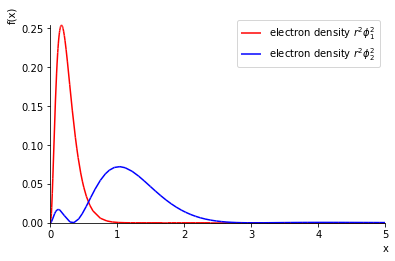

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

------------------------------ Iteration 1 ------------------------------
------- Iteration 1 needs more time to caculate Repulsion Integral ------
caculating R( 0 0 | 0 0 )
0 0 0 0
caculating l =  0
caculating m =  0
win( 0 0 0 0 0 0 ):  1
win( 0 0 0 0 0 0 ):  1
B:  42565272022343*(6250*r1/94029 + 39062500/8841452841)*exp(-94029*r1/6250)/25000000000 + (-376338845249882332826463*r1**2 - 50029624537361124337500*r1 - 3325411876745546875000)*exp(-94029*r1/6250)/(3325411876745556000000*r1) + 26603295013964375/(26603295013964448*r1)
A:  1132376488960034840682006030625/240856860959925353925219090432
finish R =  1132376488960034840682006030625/240856860959925353925219090432
4.701449999999975
caculating R( 0 0 | 0 1 )
0 0 0 0
caculating l =  0
caculating m =  0
win( 0 0 0 0 0 0 ):  1
win( 0 0 0 0 0 0 ):  1
B:  956933726562959*(50000*r1/632269 + 2500000000/399764088361)*exp(-632269*r1/50000)/1000000000000 + (-382547738821335754505620199*r1**2 - 60503953036023552397100000*r1 - 478466863281479500

B:  138631271978453*(10000*r1**3/14609 + 300000000*r1**2/213422881 + 6000000000000*r1/3117894868529 + 60000000000000000/45549326134340161)*exp(-14609*r1/10000)/500000000000000 + (-6314561019764968069898164550933*r1**4 - 17289509260770670326232225480000*r1**3 - 35504502554803211019711600000000*r1**2 - 48606342055997277048000000000000*r1 - 33271505274828720000000000000000)*exp(-14609*r1/10000)/(33271505274828770602450000000000*r1) + 665430105496574400000/(665430105496575412049*r1)
A:  2680836051535518150066129047553794382633031408725762500/7341503413959946508636957952769116942201591500817199617
finish R =  2680836051535518150066129047553794382633031408725762500/7341503413959946508636957952769116942201591500817199617
0.36516172510903966
caculating R( 0 0 | 4 5 )
0 0 1 1
caculating l =  0
caculating m =  0
win( 1 1 0 0 0 0 ):  1
win( 0 0 0 0 0 0 ):  1
B:  107615058714361*(100000*r1**3/198701 + 30000000000*r1**2/39482087401 + 6000000000000000*r1/7845130248666101 + 600000000000000000000/1558

B:  862727387042583*(2000*r1**3/5967 + 4000000*r1**2/11868363 + 16000000000*r1/70818522021 + 32000000000000/422574120899307)*exp(-5967*r1/2000)/100000000000000 + (-40507363017252854667896021109*r1**4 - 54308514184351070444640216000*r1**3 - 54608862930468648008688000000*r1**2 - 36607248486990881856000000000*r1 - 12269900615716736000000000000)*exp(-5967*r1/2000)/(14008332107812027050000000000*r1) + 245398012314334720/(280166642156240541*r1)
A:  105324090098303263719056606086582024572751006721463545/170924174740039659809004465084009391529893704971347296
finish R =  105324090098303263719056606086582024572751006721463545/170924174740039659809004465084009391529893704971347296
0.6162035900333687
caculating R( 0 1 | 2 4 )
0 0 0 1
B:  0
A:  0
finish R =  0
0.0
caculating R( 0 1 | 2 5 )
0 0 0 1
B:  0
A:  0
finish R =  0
0.0
caculating R( 0 1 | 3 0 )
0.17203376567516396
caculating R( 0 1 | 3 1 )
0.271247915504862
caculating R( 0 1 | 3 2 )
0.6162035900333687
caculating R( 0 1 | 3 3 )
0 0 0 0
cacul

B:  137078999393799*(12500*r1**3/45767 + 468750000*r1**2/2094618289 + 11718750000000*r1/95864395232663 + 146484375000000000/4387425776613287521)*exp(-45767*r1/12500)/5000000000000 + (-601423935372710946882407491482279*r1**4 - 657049768799255956128222836850000*r1**3 - 538365335940133684856083125000000*r1**2 - 294079432746374945296875000000000*r1 - 80319726207304101562500000000000)*exp(-45767*r1/12500)/(80319726207304131989442800000000*r1) + 200799315518260253906250/(200799315518260329973607*r1)
A:  2638251494989404777056365576513702623362045126780126041015625/17524000600129019257289280580724440635131952976480616538403779
finish R =  2638251494989404777056365576513702623362045126780126041015625/17524000600129019257289280580724440635131952976480616538403779
0.15055075351743488
caculating R( 0 2 | 2 3 )
0 0 0 0
caculating l =  0
caculating m =  0
win( 0 0 0 0 0 0 ):  1
win( 0 0 0 0 0 0 ):  1
B:  862727387042583*(2000*r1**3/5967 + 4000000*r1**2/11868363 + 16000000000*r1/70818522021 + 320000

B:  382117812782609*(25000*r1**2/156897 + 1250000000*r1/24616668609 + 31250000000000/3862281454746273)*exp(-156897*r1/25000)/10000000000000 + (-491948847279493026977400655419*r1**3 - 235161689171634747785522025000*r1**2 - 74941423090191255341250000000*r1 - 11941181649456531250000000000)*exp(-156897*r1/25000)/(80797383120710132650800000000*r1) + 29852954123641328125/(201993457801775331627*r1)
A:  143904128035884560696264615970235005742208188656352808593750/8176078128955910222276811638266871228079158726779102841465571
finish R =  143904128035884560696264615970235005742208188656352808593750/8176078128955910222276811638266871228079158726779102841465571
0.01760063024914626
caculating R( 0 3 | 1 4 )
0 0 0 1
B:  0
A:  0
finish R =  0
0.0
caculating R( 0 3 | 1 5 )
0 0 0 1
B:  0
A:  0
finish R =  0
0.0
caculating R( 0 3 | 2 0 )
0.0251545460223357
caculating R( 0 3 | 2 1 )
0.039528694258871816
caculating R( 0 3 | 2 2 )
0 0 0 0
caculating l =  0
caculating m =  0
win( 0 0 0 0 0 0 ):  1
win( 0 0 0

caculating m =  1
win( 0 1 1 0 0 1 ):  0
win( 0 1 1 0 0 1 ):  0
B:  0
A:  558375570446740426383105989195097590766304175822527953125000/204969672855877591963458879078230089636461005275217969525000577
finish R =  558375570446740426383105989195097590766304175822527953125000/204969672855877591963458879078230089636461005275217969525000577
0.002724186279203152
caculating R( 0 4 | 1 5 )
0 1 0 1
caculating l =  1
caculating m =  -1
win( 0 1 1 0 0 -1 ):  0
win( 0 1 1 0 0 -1 ):  0
caculating m =  0
win( 0 1 1 0 0 0 ):  1
win( 0 1 1 0 0 0 ):  1
caculating m =  1
win( 0 1 1 0 0 1 ):  0
win( 0 1 1 0 0 1 ):  0
B:  0
A:  322629143719113639566639452620786267987020144004872916500000000/40789535145588206747282999653085534626403504919195807027770120349
finish R =  322629143719113639566639452620786267987020144004872916500000000/40789535145588206747282999653085534626403504919195807027770120349
0.007909605798829732
caculating R( 0 4 | 2 0 )
0.0
caculating R( 0 4 | 2 1 )
0.0
caculating R( 0 4 | 2 2 )
0 1 0 0

caculating m =  1
win( 0 1 1 0 0 1 ):  0
win( 0 1 1 0 0 1 ):  0
B:  0
A:  1585842264901280350611485658355483138701037734780537236604296875/45224388015231728703353674948329825500773952121124423722557994684
finish R =  1585842264901280350611485658355483138701037734780537236604296875/45224388015231728703353674948329825500773952121124423722557994684
0.035066085678531755
caculating R( 0 5 | 3 5 )
0 1 0 1
caculating l =  1
caculating m =  -1
win( 0 1 1 0 0 -1 ):  0
win( 0 1 1 0 0 -1 ):  0
caculating m =  0
win( 0 1 1 0 0 0 ):  1
win( 0 1 1 0 0 0 ):  1
caculating m =  1
win( 0 1 1 0 0 1 ):  0
win( 0 1 1 0 0 1 ):  0
B:  0
A:  1495994557631335424794946282321429824810195406228345980926513671875/29617707367430666421511094341598555174103406701733236476382903561168
finish R =  1495994557631335424794946282321429824810195406228345980926513671875/29617707367430666421511094341598555174103406701733236476382903561168
0.050510140405952454
caculating R( 0 5 | 4 0 )
0.00466603966456694
caculating R( 0 5 | 4

B:  138631271978453*(10000*r1**3/14609 + 300000000*r1**2/213422881 + 6000000000000*r1/3117894868529 + 60000000000000000/45549326134340161)*exp(-14609*r1/10000)/500000000000000 + (-6314561019764968069898164550933*r1**4 - 17289509260770670326232225480000*r1**3 - 35504502554803211019711600000000*r1**2 - 48606342055997277048000000000000*r1 - 33271505274828720000000000000000)*exp(-14609*r1/10000)/(33271505274828770602450000000000*r1) + 665430105496574400000/(665430105496575412049*r1)
A:  2776320852732353628109751479484580859789940187637270000/7606745889629470032276987575426308570217383236793194837
finish R =  2776320852732353628109751479484580859789940187637270000/7606745889629470032276987575426308570217383236793194837
0.3649814116332457
caculating R( 1 1 | 4 5 )
0 0 1 1
caculating l =  0
caculating m =  0
win( 1 1 0 0 0 0 ):  1
win( 0 0 0 0 0 0 ):  1
B:  107615058714361*(100000*r1**3/198701 + 30000000000*r1**2/39482087401 + 6000000000000000*r1/7845130248666101 + 600000000000000000000/15588

B:  107615058714361*(100000*r1**3/198701 + 30000000000*r1**2/39482087401 + 6000000000000000*r1/7845130248666101 + 600000000000000000000/1558835225540202934801)*exp(-198701*r1/100000)/100000000000000 + (-167754144322523110712504742165377161*r1**4 - 337701660932804788526489030584400000*r1**3 - 509864058458897723503891320000000000*r1**2 - 513197274758453881464000000000000000*r1 - 258276140914466400000000000000000000)*exp(-198701*r1/100000)/(309742118150063863347893501000000000*r1) + 258276140914466400000000000/(309742118150063863347893501*r1)
A:  5824347281957365280341971115947485336559532109551884111552512000/45692820925490641527127623541840961555221811586662042543237531109
finish R =  5824347281957365280341971115947485336559532109551884111552512000/45692820925490641527127623541840961555221811586662042543237531109
0.12746744814584512
caculating R( 1 2 | 5 0 )
0.0
caculating R( 1 2 | 5 1 )
0.0
caculating R( 1 2 | 5 2 )
0.0
caculating R( 1 2 | 5 3 )
0.0
caculating R( 1 2 | 5 4 )
0.12746744

B:  83538156267479*(6250*r1**3/15707 + 117187500*r1**2/246709849 + 1464843750000*r1/3875071598243 + 9155273437500000/60865749593602801)*exp(-15707*r1/6250)/20000000000000 + (-5084612500887637227522239608679*r1**4 - 8092908418042333398360984925000*r1**3 - 9660790274291319234689531250000*r1**2 - 7688284104452886638671875000000*r1 - 3059258652373498535156250000000)*exp(-15707*r1/6250)/(3059258652373501424982400000000*r1) + 61185173047469970703125/(61185173047470028499648*r1)
A:  97899613599282597256049467682582043178833536910263579125/1087811048455799513609126043927041539471677255908001793536
finish R =  97899613599282597256049467682582043178833536910263579125/1087811048455799513609126043927041539471677255908001793536
0.08999689214248728
caculating R( 1 4 | 0 0 )
0.0
caculating R( 1 4 | 0 1 )
0.0
caculating R( 1 4 | 0 2 )
0.0
caculating R( 1 4 | 0 3 )
0.0
caculating R( 1 4 | 0 4 )
0.002724186279203152
caculating R( 1 4 | 0 5 )
0.00843456332017538
caculating R( 1 4 | 1 0 )
0.0
caculating R

caculating m =  1
win( 0 1 1 0 0 1 ):  0
win( 0 1 1 0 0 1 ):  0
B:  0
A:  2594290399415629589304331051803147149921165727595611316378000000000000/37019411429826408641712007059768831679384102895583691638588977744387491
finish R =  2594290399415629589304331051803147149921165727595611316378000000000000/37019411429826408641712007059768831679384102895583691638588977744387491
0.07007919086810276
caculating R( 1 5 | 3 5 )
0 1 0 1
caculating l =  1
caculating m =  -1
win( 0 1 1 0 0 -1 ):  0
win( 0 1 1 0 0 -1 ):  0
caculating m =  0
win( 0 1 1 0 0 0 ):  1
win( 0 1 1 0 0 0 ):  1
caculating m =  1
win( 0 1 1 0 0 1 ):  0
win( 0 1 1 0 0 1 ):  0
B:  0
A:  35081733556224375879354489914095671185152154647945571470000/350098253580552555412246518328154383645611970357111546465869
finish R =  35081733556224375879354489914095671185152154647945571470000/350098253580552555412246518328154383645611970357111546465869
0.10020539433554351
caculating R( 1 5 | 4 0 )
0.007909605798829732
caculating R( 1 5 | 4 1 )
0.01

B:  138631271978453*(10000*r1**3/14609 + 300000000*r1**2/213422881 + 6000000000000*r1/3117894868529 + 60000000000000000/45549326134340161)*exp(-14609*r1/10000)/500000000000000 + (-6314561019764968069898164550933*r1**4 - 17289509260770670326232225480000*r1**3 - 35504502554803211019711600000000*r1**2 - 48606342055997277048000000000000*r1 - 33271505274828720000000000000000)*exp(-14609*r1/10000)/(33271505274828770602450000000000*r1) + 665430105496574400000/(665430105496575412049*r1)
A:  185664636521870967577228817149127016854273356664513711544279765625000000/534994525274249675182908129399225904967250265740437585941356312497065251
finish R =  185664636521870967577228817149127016854273356664513711544279765625000000/534994525274249675182908129399225904967250265740437585941356312497065251
0.3470402550880222
caculating R( 2 2 | 4 5 )
0 0 1 1
caculating l =  0
caculating m =  0
win( 1 1 0 0 0 0 ):  1
win( 0 0 0 0 0 0 ):  1
B:  107615058714361*(100000*r1**3/198701 + 30000000000*r1**2/39482087401 

caculating m =  1
win( 0 1 1 0 0 1 ):  0
win( 0 1 1 0 0 1 ):  0
B:  0
A:  29455325873618819303350858657550000000000000000/175598517757554571066852117200378202546926364899
finish R =  29455325873618819303350858657550000000000000000/175598517757554571066852117200378202546926364899
0.1677424516435111
caculating R( 2 4 | 2 5 )
0 1 0 1
caculating l =  1
caculating m =  -1
win( 0 1 1 0 0 -1 ):  0
win( 0 1 1 0 0 -1 ):  0
caculating m =  0
win( 0 1 1 0 0 0 ):  1
win( 0 1 1 0 0 0 ):  1
caculating m =  1
win( 0 1 1 0 0 1 ):  0
win( 0 1 1 0 0 1 ):  0
B:  0
A:  911893513452863568449457847480099230420708184705145375000000000000000/3275187338403827265440475177257546564139402655265749955239042287204351
finish R =  911893513452863568449457847480099230420708184705145375000000000000000/3275187338403827265440475177257546564139402655265749955239042287204351
0.2784248408511733
caculating R( 2 4 | 3 0 )
0.0
caculating R( 2 4 | 3 1 )
0.0
caculating R( 2 4 | 3 2 )
0.0
caculating R( 2 4 | 3 3 )
0 1 0 0
B:  0
A

B:  135742627908873*(25000*r1**3/57641 + 1875000000*r1**2/3322484881 + 93750000000000*r1/191511351025721 + 2343750000000000000/11038905784473584161)*exp(-57641*r1/25000)/50000000000000 + (-1498450080422903543171590804160553*r1**4 - 2599625406261000924986712243300000*r1**3 - 3382521217008293911868347500000000*r1**2 - 2934127805735755722375000000000000*r1 - 1272587136645684375000000000000000)*exp(-57641*r1/25000)/(1272587136645683729248402000000000*r1) + 636293568322842187500000/(636293568322841864624201*r1)
A:  11766519991649511192299661955240631103515625/28095939007929427177685226587489247243521444
finish R =  11766519991649511192299661955240631103515625/28095939007929427177685226587489247243521444
0.41879789062500045
caculating R( 3 3 | 3 4 )
0 0 0 1
B:  0
A:  0
finish R =  0
0.0
caculating R( 3 3 | 3 5 )
0 0 0 1
B:  0
A:  0
finish R =  0
0.0
caculating R( 3 3 | 4 0 )
0.0
caculating R( 3 3 | 4 1 )
0.0
caculating R( 3 3 | 4 2 )
0.0
caculating R( 3 3 | 4 3 )
0.0
caculating R( 3 3 | 4 4 

caculating R( 4 4 | 2 4 )
0.0
caculating R( 4 4 | 2 5 )
0.0
caculating R( 4 4 | 3 0 )
0.026239921787159684
caculating R( 4 4 | 3 1 )
0.05360965698246723
caculating R( 4 4 | 3 2 )
0.29458149218349966
caculating R( 4 4 | 3 3 )
0.3168148738969522
caculating R( 4 4 | 3 4 )
0.0
caculating R( 4 4 | 3 5 )
0.0
caculating R( 4 4 | 4 0 )
0.0
caculating R( 4 4 | 4 1 )
0.0
caculating R( 4 4 | 4 2 )
0.0
caculating R( 4 4 | 4 3 )
0.0
caculating R( 4 4 | 4 4 )
1 1 1 1
caculating l =  0
caculating m =  0
win( 1 1 0 0 0 0 ):  1
win( 1 1 0 0 0 0 ):  1
caculating l =  1
caculating m =  -1
win( 1 1 1 0 0 -1 ):  0
win( 1 1 1 0 0 -1 ):  0
caculating m =  0
win( 1 1 1 0 0 0 ):  0
win( 1 1 1 0 0 0 ):  0
caculating m =  1
win( 1 1 1 0 0 1 ):  0
win( 1 1 1 0 0 1 ):  0
caculating l =  2
caculating m =  -2
win( 1 1 2 0 0 -2 ):  0
win( 1 1 2 0 0 -2 ):  0
caculating m =  -1
win( 1 1 2 0 0 -1 ):  0
win( 1 1 2 0 0 -1 ):  0
caculating m =  0
win( 1 1 2 0 0 0 ):  1
win( 1 1 2 0 0 0 ):  1
caculating m =  1
win( 1 1 2 0 

caculating l =  1
caculating m =  -1
win( 1 1 1 0 0 -1 ):  0
win( 1 1 1 0 0 -1 ):  0
caculating m =  0
win( 1 1 1 0 0 0 ):  0
win( 1 1 1 0 0 0 ):  0
caculating m =  1
win( 1 1 1 0 0 1 ):  0
win( 1 1 1 0 0 1 ):  0
caculating l =  2
caculating m =  -2
win( 1 1 2 0 0 -2 ):  0
win( 1 1 2 0 0 -2 ):  0
caculating m =  -1
win( 1 1 2 0 0 -1 ):  0
win( 1 1 2 0 0 -1 ):  0
caculating m =  0
win( 1 1 2 0 0 0 ):  1
win( 1 1 2 0 0 0 ):  1
caculating m =  1
win( 1 1 2 0 0 1 ):  0
win( 1 1 2 0 0 1 ):  0
caculating m =  2
win( 1 1 2 0 0 2 ):  0
win( 1 1 2 0 0 2 ):  0
B:  0
A:  73874207910083889304945441622829437255859375/122030700021303408732744470930813102130724864
finish R =  73874207910083889304945441622829437255859375/122030700021303408732744470930813102130724864
0.6053739583333322


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

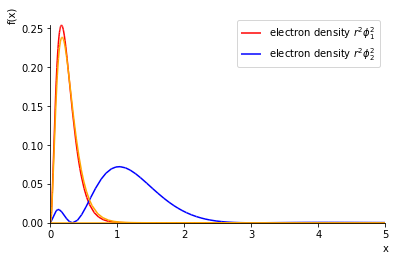

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 73.5 s
------------------------------ Iteration 2 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

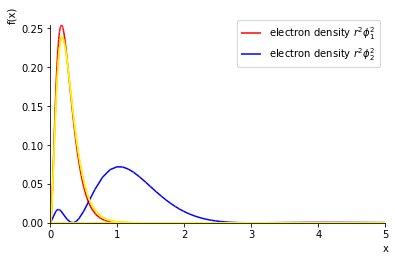

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.8 s
------------------------------ Iteration 3 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

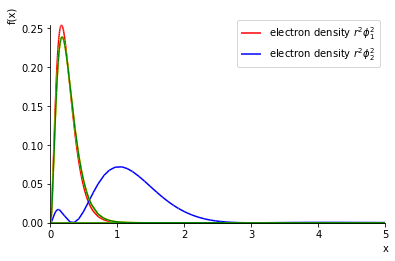

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.5 s
------------------------------ Iteration 4 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

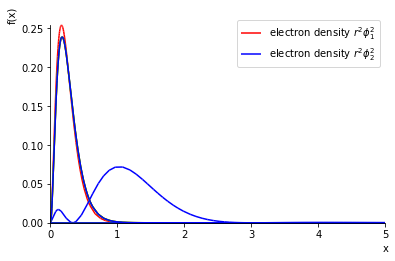

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.5 s
------------------------------ Iteration 5 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

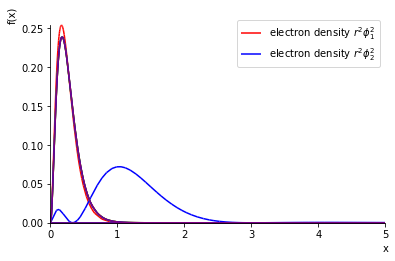

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.6 s
------------------------------ Iteration 6 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

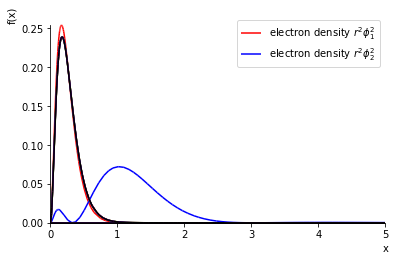

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 4.3 s
------------------------------ Iteration 7 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

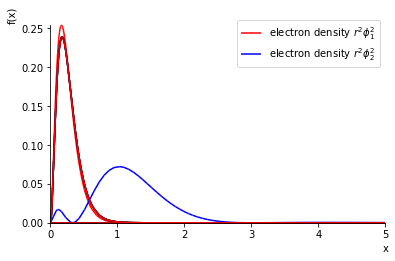

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.5 s
------------------------------ Iteration 8 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

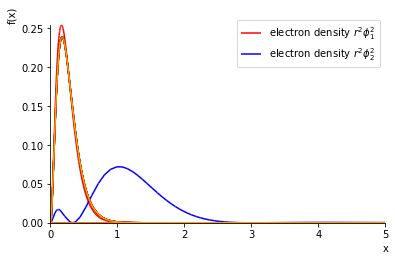

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.7 s
------------------------------ Iteration 9 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

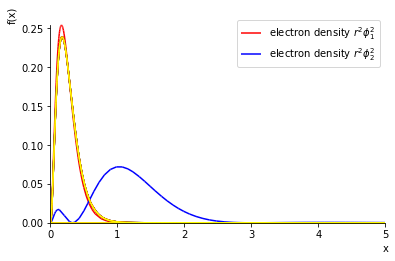

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.7 s
------------------------------ Iteration 10 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

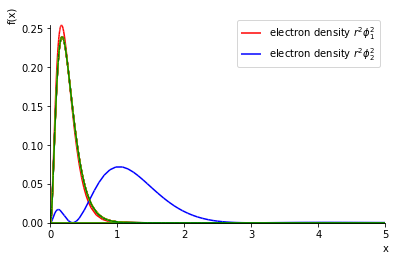

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.6 s


In [458]:
# input 
# input for zeta
# zetas = [[5.59108, 1, 0, 0], [3.35538, 1, 0, 0], [1.01122, 2, 0, 0], [0.61000, 2, 0, 0]]
zetas = [[7.52232, 1, 0, 0], [5.12306, 1, 0, 0], [1.83068, 2, 0, 0], [1.15282, 2, 0, 0], [0.73045, 2, 1, 0], [1.25656, 2, 1, 0]]
# zetas = [[11.4216, 1, 0, 0], [8.50182, 1, 0, 0], [3.56883, 2, 0, 0], [2.19285, 2, 0, 0], [4.68773, 2, 1, 0], [2.05684, 2, 1, 0]]
# input nuclear charge (element number)
Z = 6

# build basis function
f1=STO(zetas[0][0], zetas[0][1], zetas[0][2], zetas[0][3])
f2=STO(zetas[1][0], zetas[1][1], zetas[1][2], zetas[1][3])
f3=STO(zetas[2][0], zetas[2][1], zetas[2][2], zetas[2][3])
f4=STO(zetas[3][0], zetas[3][1], zetas[3][2], zetas[3][3])
f5=STO(zetas[4][0], zetas[4][1], zetas[4][2], zetas[4][3])
f6=STO(zetas[5][0], zetas[5][1], zetas[5][2], zetas[5][3])

# fs = [f1, f2, f3, f4]
fs = [f1, f2, f3, f4, f5, f6]

# initialization
R = np.zeros((len(zetas), len(zetas), len(zetas), len(zetas)))
H = H_matrix(fs, Z)
print(H)
S = S_matrix(fs)
print(S)
e, Co = secular_eqn(H, S)
P = P_matrix(Co)
scf_H = get_E0(e, P, H)

##############################################print information below#################################################
print('-'*30, "Initialization", '-'*30)
print('-'*25, "Ignore repulsion integral", '-'*24)
display(Math('\zeta_1 = {0} \quad \zeta_2 = {1} \quad \zeta_3 = {2} \quad \zeta_4 = {3}'.format(format(zetas[0][0], '0.3f'), format(zetas[1][0], '0.3f'), format(zetas[2][0], '0.3f'),format(zetas[3][0], '0.3f')))) 
# display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][0], '0.3f'), format(Co[1][0], '0.3f'), format(Co[2][0], '0.3f'), format(Co[3][0], '0.3f'), format(Co[4][0], '0.3f'), format(Co[5][0], '0.3f')))) 
# display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][1], '0.3f'), format(Co[1][1], '0.3f'), format(Co[2][1], '0.3f'), format(Co[3][1], '0.3f'), format(Co[4][1], '0.3f'), format(Co[5][1], '0.3f')))) 
# display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][2], '0.3f'), format(Co[1][2], '0.3f'), format(Co[2][2], '0.3f'), format(Co[3][2], '0.3f'), format(Co[4][2], '0.3f'), format(Co[5][2], '0.3f')))) 
# display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][3], '0.3f'), format(Co[1][3], '0.3f'), format(Co[2][3], '0.3f'), format(Co[3][3], '0.3f'), format(Co[4][3], '0.3f'), format(Co[5][3], '0.3f')))) 
# display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][4], '0.3f'), format(Co[1][4], '0.3f'), format(Co[2][4], '0.3f'), format(Co[3][4], '0.3f'), format(Co[4][4], '0.3f'), format(Co[5][4], '0.3f')))) 
# display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][5], '0.3f'), format(Co[1][5], '0.3f'), format(Co[2][5], '0.3f'), format(Co[3][5], '0.3f'), format(Co[4][5], '0.3f'), format(Co[5][5], '0.3f')))) 

# plot density graph
colorlist = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black']
phi1 = Co[0,0]*f1+Co[1,0]*f2+Co[2,0]*f3+Co[3,0]*f4
phi2 = Co[0,1]*f1+Co[1,1]*f2+Co[2,1]*f3+Co[3,1]*f4
density_1 = phi1*phi1*r*r
density_2 = phi2*phi2*r*r    
p = plot((density_1, (r, 0, 5)), (density_2, (r, 0, 5)), show = False, legend = True)
p[0].label = 'electron density $r^2 \phi_1^2$ '
p[1].label = 'electron density $r^2 \phi_2^2$ '    
p[0].line_color = colorlist[0]
p[1].line_color = 'blue'
p.show()
# print energy result
display(Math(' \epsilon_1 \; for \; \phi_1  = {0} '.format(format(e[0].real, '0.3f'))))    
display(Math(' \epsilon_2 \; for \; \phi_1 = {0} '.format(format(e[1].real, '0.3f'))))
display(Math(' \epsilon_3 \; for \; \phi_1  = {0} '.format(format(e[2].real, '0.3f'))))    
display(Math(' \epsilon_4 \; for \; \phi_1  = {0} '.format(format(e[3].real, '0.3f'))))    
# display(Math(' \epsilon_5 \; for \; \phi_1  = {0} '.format(format(e[4].real, '0.3f'))))    
# display(Math(' \epsilon_6 \; for \; \phi_1  = {0} '.format(format(e[5].real, '0.3f'))))    
display(Math(' Hartree \ Fork \; atom \; energy = {0} \ hartree = {1} \ eV'.format(format(scf_H, '0.5f'), format(scf_H*27.211, '0.5f'))))    
##############################################print information above#################################################

for i in range(10):
    print('-'*30, "Iteration", i + 1, '-'*30)
    if(i==0):
        print('-'*7, "Iteration 1 needs more time to caculate Repulsion Integral", '-'*6)
        start = time.time()
        R = R_matrix(zetas)
    else:
        start = time.time()
    F = F_matrix(fs, Z, zetas, Co, R)
    S = S_matrix(fs)
    e, Co = secular_eqn(F, S)
    P = P_matrix(Co)
    scf_H = get_E0(e, P, H)
    ##########################################print information below#################################################
    # print information
    display(Math('\zeta_1 = {0} \quad \zeta_2 = {1} \quad \zeta_3 = {2} \quad \zeta_4 = {3}'.format(format(zetas[0][0], '0.3f'), format(zetas[1][0], '0.3f'), format(zetas[2][0], '0.3f'),format(zetas[3][0], '0.3f')))) 
    display(Math('Orbitals:'))
    display(Math(' \phi_1 = c_{11} \chi_1 + c_{21} \chi_2 + c_{31} \chi_3 + c_{41} \chi_4'))
    display(Math(' \phi_2 = c_{12} \chi_1 + c_{22} \chi_2 + c_{32} \chi_3 + c_{42} \chi_4'))    
#     display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][0], '0.3f'), format(Co[1][0], '0.3f'), format(Co[2][0], '0.3f'), format(Co[3][0], '0.3f'), format(Co[4][0], '0.3f'), format(Co[5][0], '0.3f')))) 
#     display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][1], '0.3f'), format(Co[1][1], '0.3f'), format(Co[2][1], '0.3f'), format(Co[3][1], '0.3f'), format(Co[4][1], '0.3f'), format(Co[5][1], '0.3f')))) 
#     display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][2], '0.3f'), format(Co[1][2], '0.3f'), format(Co[2][2], '0.3f'), format(Co[3][2], '0.3f'), format(Co[4][2], '0.3f'), format(Co[5][2], '0.3f')))) 
#     display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][3], '0.3f'), format(Co[1][3], '0.3f'), format(Co[2][3], '0.3f'), format(Co[3][3], '0.3f'), format(Co[4][3], '0.3f'), format(Co[5][3], '0.3f')))) 
#     display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][4], '0.3f'), format(Co[1][4], '0.3f'), format(Co[2][4], '0.3f'), format(Co[3][4], '0.3f'), format(Co[4][4], '0.3f'), format(Co[5][4], '0.3f')))) 
#     display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c11 = {4} \quad c21 = {5}'.format(format(Co[0][5], '0.3f'), format(Co[1][5], '0.3f'), format(Co[2][5], '0.3f'), format(Co[3][5], '0.3f'), format(Co[4][5], '0.3f'), format(Co[5][5], '0.3f'))))     
    # plot density graph
    phi1 = Co[0,0]*f1+Co[1,0]*f2+Co[2,0]*f3+Co[3,0]*f4
    phi2 = Co[0,1]*f1+Co[1,1]*f2+Co[2,1]*f3+Co[3,1]*f4
    density_1 = phi1*phi1*r*r
    density_2 = phi2*phi2*r*r    
    p1 = plot((density_1, (r, 0, 5)), (density_2, (r, 0, 5)), show = False, legend = True)
    p1[0].label = None 
    p1[1].label = None     
    p1[0].line_color = colorlist[i+1]
    p1[1].line_color = colorlist[i+1]
    p.extend(p1)
    p.show() 
    # print energy result
    display(Math(' \epsilon_1 \; for \; \phi_1  = {0} '.format(format(e[0].real, '0.3f'))))    
    display(Math(' \epsilon_2 \; for \; \phi_1 = {0} '.format(format(e[1].real, '0.3f'))))
    display(Math(' \epsilon_3 \; for \; \phi_1  = {0} '.format(format(e[2].real, '0.3f'))))    
    display(Math(' \epsilon_4 \; for \; \phi_1  = {0} '.format(format(e[3].real, '0.3f'))))    
#     display(Math(' \epsilon_5 \; for \; \phi_1  = {0} '.format(format(e[4].real, '0.3f'))))    
#     display(Math(' \epsilon_6 \; for \; \phi_1  = {0} '.format(format(e[5].real, '0.3f'))))         
    display(Math(' Hartree \ Fork \; atom \; energy = {0} \ hartree = {1} \ eV'.format(format(scf_H, '0.5f'), format(scf_H*27.211, '0.5f'))))    
    stop = time.time()
    print('Time used:',format(stop-start, '0.1f'),'s')
    ##########################################print information above#################################################    

In [459]:
e

array([-1.13765142e+01+0.j, -1.24391701e+00+0.j, -1.09046837e+00+0.j,
       -1.58072519e-02+0.j,  4.89931016e-01+0.j,  2.20570406e+01+0.j])

Reference

[1] Levine, Quantum Chemistry, 7th Edition, chapter 14  
[2] C. Roetti and E. Clementi, J. Chem. Phys., 60, 4725 (1974)  
[3] Acosta C R. Restricted closed shell Hartree Fock Roothaan matrix method applied to Helium atom using   Mathematica[J]. European Journal of Physics Education, 2017, 5(1): 1-14.  
[4] [Simple Quantum Chemistry: Hartree-Fock in Python, 2018](http://nznano.blogspot.com/2018/03/simple-quantum-chemistry-hartree-fock.html)  
[5] [Helium hartree fork, prtkm, 2015](https://github.com/prtkm/helium-hartree-fock/)

In [338]:
R

array([[[[4.70145   , 4.05820548, 0.47084801, 0.18838955, 0.        ,
          0.        ],
         [4.05820548, 3.78199742, 0.67605384, 0.29294212, 0.        ,
          0.        ],
         [0.47084801, 0.67605384, 0.91183551, 0.65200415, 0.        ,
          0.        ],
         [0.18838955, 0.29294212, 0.65200415, 0.57591852, 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.36516173,
          0.41400104],
         [0.        , 0.        , 0.        , 0.        , 0.41400104,
          0.62756436]],

        [[4.05820548, 3.54009007, 0.4283202 , 0.17203377, 0.        ,
          0.        ],
         [3.54009007, 3.34085851, 0.62353938, 0.27124792, 0.        ,
          0.        ],
         [0.4283202 , 0.62353938, 0.86074356, 0.61620359, 0.        ,
          0.        ],
         [0.17203377, 0.27124792, 0.61620359, 0.54473602, 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.34557089

In [460]:
for i in range(Co.shape[0]):
    print(format(Co[0,i], '0.3f'), format(Co[2,i], '0.3f'), format(Co[2,i], '0.3f'), format(Co[3,i], '0.3f'),format(Co[4,i], '0.3f'),format(Co[5,i], '0.3f'))

0.232 0.009 0.009 0.000 0.000 0.000
0.000 0.000 0.000 0.000 -0.742 1.531
0.017 0.940 0.940 0.123 0.000 0.000
0.000 0.000 0.000 0.000 -1.653 0.969
-0.124 -2.078 -2.078 2.176 0.000 0.000
3.612 1.165 1.165 -0.727 0.000 0.000


In [ ]:
e

In [ ]:
Co

In [233]:
e

array([-11.40936426+0.j,  -0.88568191+0.j,  -0.59865911+0.j,
         0.08159798+0.j,   0.52292146+0.j,  21.99889652+0.j])

In [176]:
R

array([[[[4.70145   , 4.05820548, 0.47084801, 0.18838955, 0.        ,
          0.        ],
         [4.05820548, 3.78199742, 0.67605384, 0.29294212, 0.        ,
          0.        ],
         [0.47084801, 0.67605384, 0.91183551, 0.65200415, 0.        ,
          0.        ],
         [0.18838955, 0.29294212, 0.65200415, 0.57591852, 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.36516173,
          0.41400104],
         [0.        , 0.        , 0.        , 0.        , 0.41400104,
          0.62756436]],

        [[4.05820548, 3.54009007, 0.4283202 , 0.17203377, 0.        ,
          0.        ],
         [3.54009007, 3.34085851, 0.62353938, 0.27124792, 0.        ,
          0.        ],
         [0.4283202 , 0.62353938, 0.86074356, 0.61620359, 0.        ,
          0.        ],
         [0.17203377, 0.27124792, 0.61620359, 0.54473602, 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.34557089

In [231]:
R

array([[[[4.70145   , 4.05820548, 0.47084801, 0.18838955, 0.        ,
          0.        ],
         [4.05820548, 3.78199742, 0.67605384, 0.29294212, 0.        ,
          0.        ],
         [0.47084801, 0.67605384, 0.91183551, 0.65200415, 0.        ,
          0.        ],
         [0.18838955, 0.29294212, 0.65200415, 0.57591852, 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.36516173,
          0.41400104],
         [0.        , 0.        , 0.        , 0.        , 0.41400104,
          0.62756436]],

        [[4.05820548, 3.54009007, 0.4283202 , 0.17203377, 0.        ,
          0.        ],
         [3.54009007, 3.34085851, 0.62353938, 0.27124792, 0.        ,
          0.        ],
         [0.4283202 , 0.62353938, 0.86074356, 0.61620359, 0.        ,
          0.        ],
         [0.17203377, 0.27124792, 0.61620359, 0.54473602, 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.34557089

In [382]:
R

array([[[[2.78077506e-01, 2.23847703e-01, 1.56355934e-02,
          5.39398707e-03],
         [2.23847703e-01, 2.05981371e-01, 2.66161745e-02,
          1.01312938e-02],
         [1.56355934e-02, 2.66161745e-02, 4.01755233e-02,
          2.75197349e-02],
         [5.39398707e-03, 1.01312938e-02, 2.75197349e-02,
          2.42647579e-02]],

        [[2.23847703e-01, 1.83348036e-01, 1.35129229e-02,
          4.68060061e-03],
         [1.83348036e-01, 1.72423429e-01, 2.35338249e-02,
          8.99396678e-03],
         [1.35129229e-02, 2.35338249e-02, 3.64146002e-02,
          2.49629035e-02],
         [4.68060061e-03, 8.99396678e-03, 2.49629035e-02,
          2.20208345e-02]],

        [[1.56355934e-02, 1.35129229e-02, 1.18329057e-03,
          4.16132051e-04],
         [1.35129229e-02, 1.36429315e-02, 2.25494783e-03,
          8.76714813e-04],
         [1.18329057e-03, 2.25494783e-03, 3.92847907e-03,
          2.70828457e-03],
         [4.16132051e-04, 8.76714813e-04, 2.70828457e-03,
   